In [1]:
# MNIST
# DataLoader, Transformation
# Multilayer Neural Net, activation function
# Loss and Optimizer
# Training Loop (batch training)
# Model evaluation
# GPU support

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# TensorBoard

In [3]:
# start with command "tensorboard --logdir=runs"

In [4]:
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist")

In [5]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 784 #28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [6]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


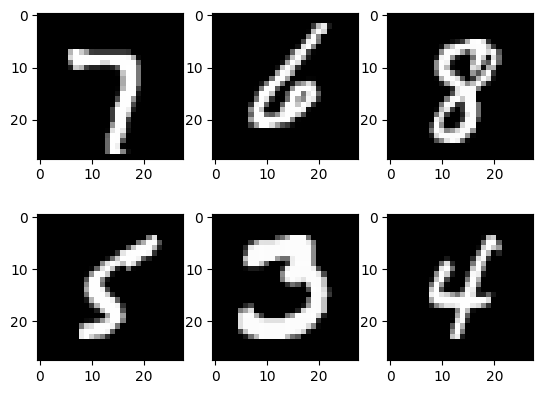

In [8]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
#plt.show()
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close()

In [9]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # don't want Softmax here
        return out

In [10]:
%%time
model = NeuralNet(input_size, hidden_size, num_classes)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer.add_graph(model, samples)
writer.close()

# training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        # 100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #backwards
        optimizer.zero_grad() # empty the values in the gradient attribute
        loss.backward()
        optimizer.step()      # updates the parameters 
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
        if (i+1) % 100 ==0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0

mat1 and mat2 shapes cannot be multiplied (2800x28 and 784x100)
Error occurs, No graph saved


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2800x28 and 784x100)

In [11]:
# test
# In test phase, we don't need to compute graidents (for memory efficiency)

labels1 = []
pred = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels2 in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels2 = labels2.to(device)
        outputs = model(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels2.shape[0]
        n_correct += (predictions == labels2).sum().item()
        
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        
        pred.append(class_predictions)
        labels1.append(predicted)
    
    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels1 = torch.cat(labels1)
    
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')
    
    classes = range(10)
    for i in classes:
        labels_i = labels ==i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

NameError: name 'predicted' is not defined